# Import Dataset & Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

df = pd.read_csv("clicked-ads-dataset.csv").drop("Unnamed: 0", axis=1)
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('[^0-9a-zA-Z_]', '', regex=True)
)
df.rename({'male': 'gender'}, axis=1, inplace=True)
df.sample(5)

,daily_time_spent_on_site,age,area_income,daily_internet_usage,gender,timestamp,clicked_on_ad,city,province,category
566,47.90,42,339273760.0,114.53,Perempuan,2/24/2016 19:08,Yes,Pakanbaru,Riau,House
575,48.86,54,372320830.0,134.46,Perempuan,1/9/2016 17:33,Yes,Jakarta Selatan,Daerah Khusus Ibukota Jakarta,Furniture
915,34.04,34,281279880.0,174.88,Laki-Laki,2/16/2016 7:37,Yes,Bandung,Jawa Barat,Health
142,55.60,44,461676320.0,124.38,Laki-Laki,6/14/2016 11:59,Yes,Bekasi,Jawa Barat,Finance
616,52.70,41,287417480.0,109.34,Laki-Laki,1/31/2016 8:50,Yes,Makassar,Sulawesi Selatan,House


In [39]:
df.shape

(1000, 10)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   daily_time_spent_on_site  987 non-null    float64
 1   age                       1000 non-null   int64  
 2   area_income               987 non-null    float64
 3   daily_internet_usage      989 non-null    float64
 4   gender                    997 non-null    object 
 5   timestamp                 1000 non-null   object 
 6   clicked_on_ad             1000 non-null   object 
 7   city                      1000 non-null   object 
 8   province                  1000 non-null   object 
 9   category                  1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 78.2+ KB


# Custom Functions

In [41]:
# ==== Data Cleaning & Feature Engineering ====
def prepare(df):
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()
    
    # Impute missing values
    impute_vals = {'daily_time_spent_on_site': df['daily_time_spent_on_site'].mean(),
                   'area_income': df['area_income'].median(),
                   'daily_internet_usage': df['daily_internet_usage'].mean(),
                   'gender': df['gender'].mode()[0]
                  }
    
    df.fillna(impute_vals, inplace=True)

    # jam saat user mengakses situs
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
    
    # hari dalam seminggu (0=Senin, ..., 6=Minggu)
    df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
    
    # apakah akses dilakukan di akhir pekan
    df['is_weekend'] = df['day_of_week'].isin([5,6])
    
    # bagian dari hari (pagi, siang, sore, malam)
    def get_part_of_day(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 21:
            return 'evening'
        else:
            return 'night'
    df['part_of_day'] = df['hour'].apply(get_part_of_day)
    
    # drop timestamp
    df = df.drop("timestamp", axis=1)

    # convert label to int
    df['clicked_on_ad'] = df['clicked_on_ad'].map({'No': 0, 'Yes': 1})

    df = df.reset_index(drop=True)

    return df

# ==== Get Models ====
def get_classifiers():
    models = [
        LogisticRegression(max_iter=1000),
        KNeighborsClassifier(n_jobs=-1),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1),
        GradientBoostingClassifier(random_state=42),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        SVC(probability=True, random_state=42),
        LGBMClassifier(random_state=42, n_jobs=-1),
        CatBoostClassifier(random_state=42, verbose=0)
    ]
    
    names = ['LogReg', 'KNN', 'DecisionTree', 'RandomForest', 'GradientBoost', 'XGBoost', 'SVM', 'LGBM', 'CatBoost']
    return models, names

# ==== Evaluation Function ====
def evaluate_classifier(X, y, pipeline):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracy = cross_val_score(pipeline, X, y, scoring='accuracy', cv=skf, n_jobs=-1)
    recall = cross_val_score(pipeline, X, y, scoring='recall', cv=skf, n_jobs=-1)
    precision = cross_val_score(pipeline, X, y, scoring='precision', cv=skf, n_jobs=-1)
    f1 = cross_val_score(pipeline, X, y, scoring='f1', cv=skf, n_jobs=-1)
    roc_auc = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=skf, n_jobs=-1)

    return {
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# ==== Feature Importance ====
def plot_feature_importance(pipeline, model_name, X, y, top_n=15):
    # Fit pipeline
    pipeline.fit(X, y)

    # Ambil model setelah preprocessing dan SMOTE
    clf = pipeline.named_steps['classifier']

    # Ambil nama fitur dari preprocessor
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Ambil nilai feature importance
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.abs(clf.coef_).flatten()
    else:
        print(f"Model {model_name} tidak mendukung feature importance secara langsung.")
        return

    # Buat DataFrame untuk visualisasi
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(top_n)

    # Visualisasi
    plt.figure(figsize=(10, 6))
    plt.barh(fi_df['feature'], fi_df['importance'])
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.gca().invert_yaxis()
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return fi_df

# Cleaning for EDA

In [42]:
df.isnull().sum()

daily_time_spent_on_site    13
age                          0
area_income                 13
daily_internet_usage        11
gender                       3
timestamp                    0
clicked_on_ad                0
city                         0
province                     0
category                     0
dtype: int64

Missing values in the `daily_time_spent_on_site` and `daily_internet_usage` columns were imputed using the median because both columns have highly skewed distributions, meaning the data is not normally distributed and is more concentrated on one side. Using the median is more appropriate in this situation as it is not affected by extreme values or outliers. Meanwhile, the `area_income` column was imputed using the mean because its distribution tends to be more normal and even, making the average a more accurate representation. For the `gender` column, which is categorical data, missing values were imputed using the mode, i.e., the most frequently occurring value, to ensure that the imputation still reflects the existing data distribution proportions.

In [43]:
# Impute missing values
impute_vals = {'daily_time_spent_on_site': df['daily_time_spent_on_site'].mean(),
               'area_income': df['area_income'].median(),
               'daily_internet_usage': df['daily_internet_usage'].mean(),
               'gender': df['gender'].mode()[0]
              }

df.fillna(impute_vals, inplace=True)

In [44]:
df.isnull().sum()

daily_time_spent_on_site    0
age                         0
area_income                 0
daily_internet_usage        0
gender                      0
timestamp                   0
clicked_on_ad               0
city                        0
province                    0
category                    0
dtype: int64

In [45]:
df.duplicated().sum()

np.int64(0)

There are no duplicate values in the dataset, so we can proceed to the next step.


# EDA

## Overview

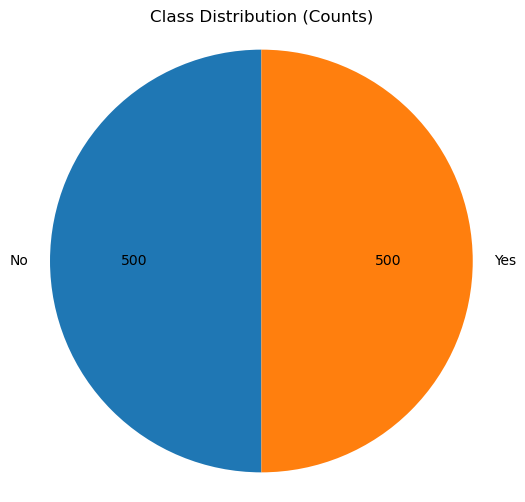

In [77]:
# Check class distribution
# Get counts
counts = df['clicked_on_ad'].value_counts()
labels = counts.index
sizes = counts.values

# Define a function to show the actual number
def absolute_value(val):
    total = sum(sizes)
    count = int(round(val/100 * total))
    return f'{count}'

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct=absolute_value,
    startangle=90
)
plt.title('Class Distribution (Counts)')
plt.axis('equal')
plt.show()

In [46]:
numerical_columns = ['daily_time_spent_on_site', 'age', 'area_income', 'daily_internet_usage']
categorical_columns = ['gender', 'province', 'city', 'category']
target = ['clicked_on_ad']

In [47]:
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()}")

gender: 2
province: 16
city: 30
category: 10


In [48]:
# Check values on city column
cities = (df.city
                .apply(lambda x: x.split())
                .explode()
                .value_counts()
        )
cities.head(15)

city
Jakarta      253
Selatan       94
Tangerang     65
Surabaya      64
Bandung       64
Timur         63
Barat         57
Bekasi        56
Medan         48
Utara         45
Palembang     42
Semarang      41
Batam         34
Makassar      33
Depok         30
Name: count, dtype: int64

In [49]:
# Check values on province column
provinces = (df.province
                .apply(lambda x: x.split())
                .explode()
                .value_counts()
        )
provinces.head(15)

province
Jawa          353
Daerah        253
Khusus        253
Ibukota       253
Jakarta       253
Barat         241
Timur         124
Sumatra       109
Selatan        98
Banten         76
Kalimantan     69
Riau           57
Tengah         53
Utara          48
Kepulauan      34
Name: count, dtype: int64

In [50]:
# Check values on category column
categories = (df.category
                .apply(lambda x: x.split())
                .explode()
                .value_counts()
        )
categories.head(15)

category
Otomotif      112
House         109
Health        104
Fashion       102
Food           99
Furniture      98
Travel         98
Electronic     97
Finance        91
Bank           90
Name: count, dtype: int64

## Univariate

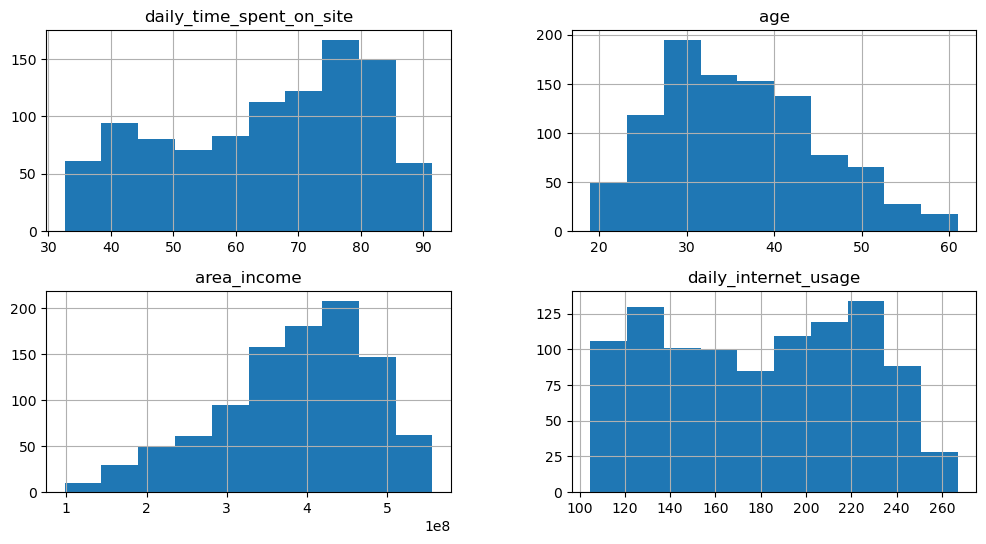

In [51]:
X_num = df[numerical_columns]

X_num.hist(figsize=(12, 6))
plt.show()

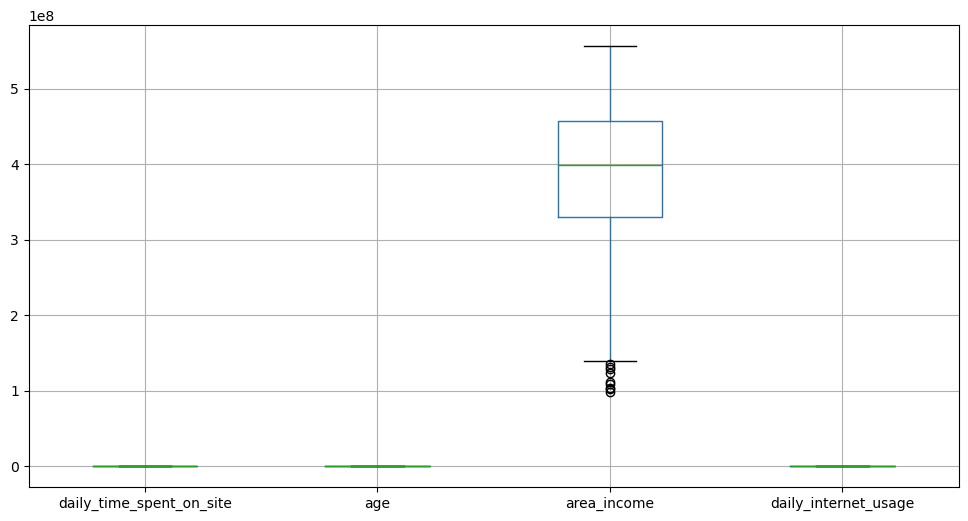

In [52]:
X_num.boxplot(figsize=(12, 6))
plt.show()

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform='pandas')
X_num_scaled = scaler.fit_transform(X_num)
X_num_scaled.describe()

,daily_time_spent_on_site,age,area_income,daily_internet_usage
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-3.286260e-16,-3.019807e-17,2.167155e-16,1.421085e-16
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-2.054834e+00,-1.936986e+00,-3.072511e+00,-1.721859e+00
25%,-8.507079e-01,-7.981854e-01,-5.911102e-01,-9.367060e-01
50%,1.811736e-01,-1.149050e-01,1.500434e-01,2.755072e-02
75%,8.531519e-01,6.822554e-01,7.667946e-01,8.811578e-01
max,1.684346e+00,2.845977e+00,1.833874e+00,1.998489e+00


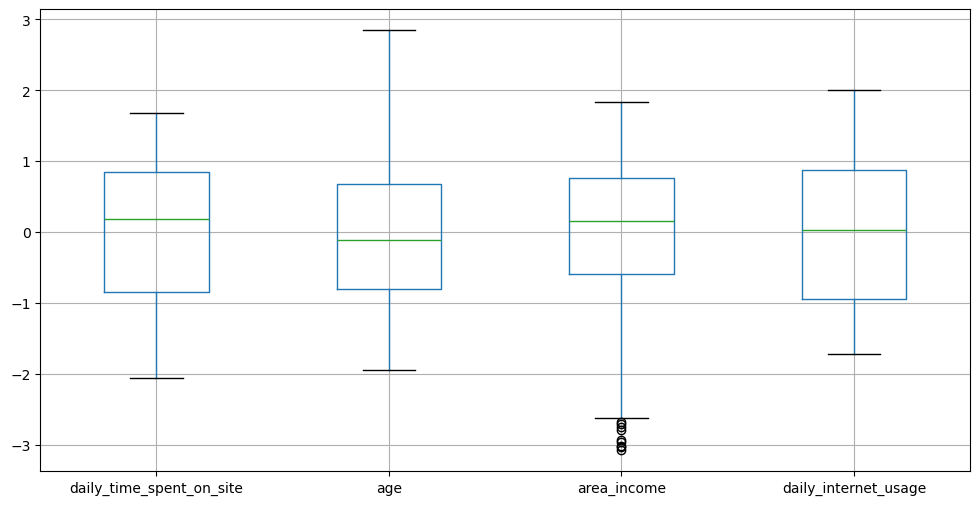

In [54]:
X_num_scaled.boxplot(figsize=(12, 6))
plt.show()

## Bivariate

### Numerical

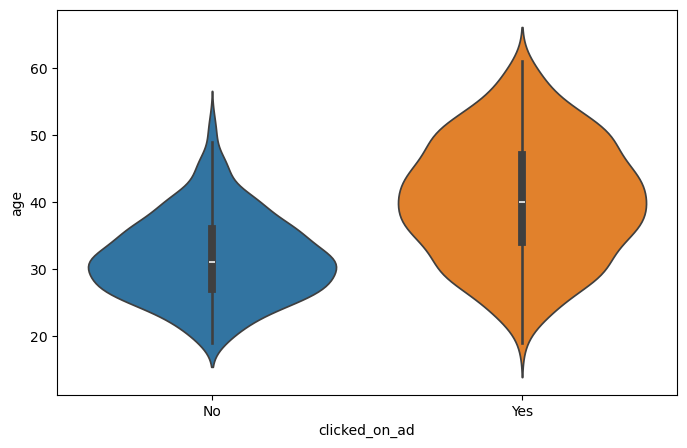

In [55]:
plt.figure(figsize=(8,5))
sns.violinplot(x='clicked_on_ad', y='age', hue='clicked_on_ad', data=df)
plt.show()

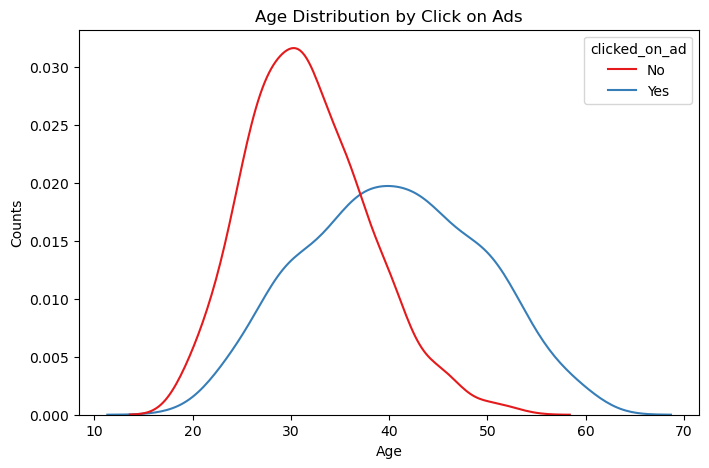

In [56]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='age', hue='clicked_on_ad', palette='Set1')
plt.title('Age Distribution by Click on Ads')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.show()

People who did **not click** on the ad (**red line**) are predominantly in the **around 30 years old** age group. Their age distribution is highly concentrated between **28 and 36 years**. On the other hand, those who **clicked** on the ad (**blue line**) have a more even age distribution and tend to be older, with a peak around **40 years old**. Their age range is broader, spanning from the mid-30s to the 40s.

This data suggests that the most responsive target market for our ads is **more mature consumers, particularly around the age of 40**. In contrast, the 30s age group shows a lower tendency to click on ads.

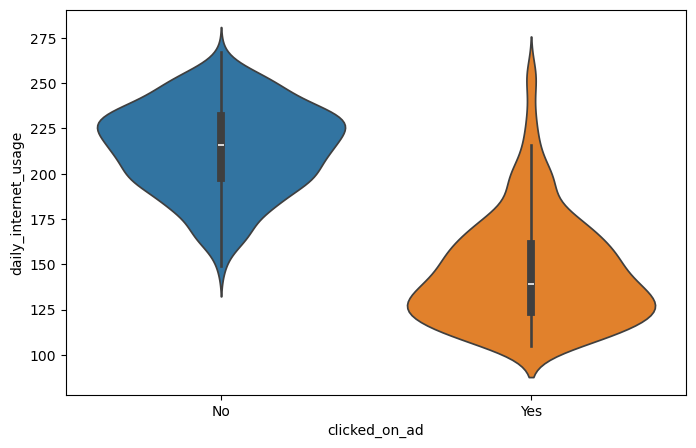

In [57]:
plt.figure(figsize=(8,5))
sns.violinplot(x='clicked_on_ad', y='daily_internet_usage', hue='clicked_on_ad', data=df)
plt.show()

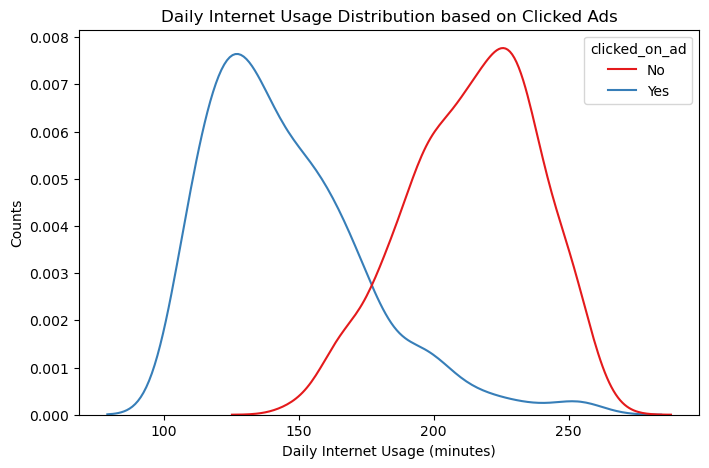

In [58]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='daily_internet_usage', hue='clicked_on_ad', palette='Set1')
plt.title('Daily Internet Usage Distribution based on Clicked Ads')
plt.xlabel('Daily Internet Usage (minutes)')
plt.ylabel('Counts')
plt.show()

Customers who clicked on the ad generally have a daily internet usage duration between **120 and 160 minutes**, which is under 3 hours. In contrast, customers who did **not** click on the ad tend to have **longer internet usage durations**, typically ranging from **200 to 230 minutes**.


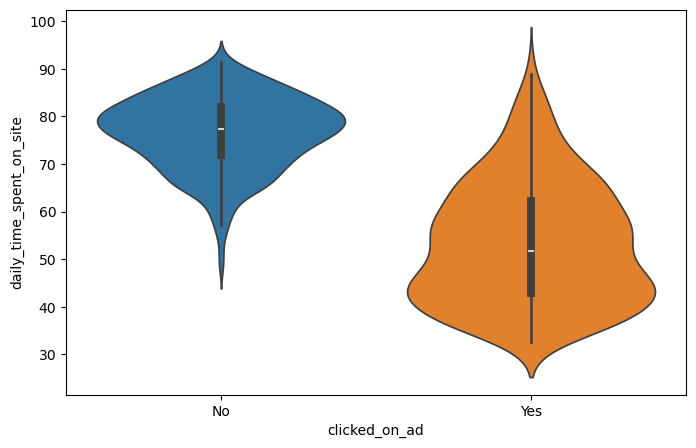

In [59]:
plt.figure(figsize=(8,5))
sns.violinplot(x='clicked_on_ad', y='daily_time_spent_on_site', hue='clicked_on_ad', data=df)
plt.show()

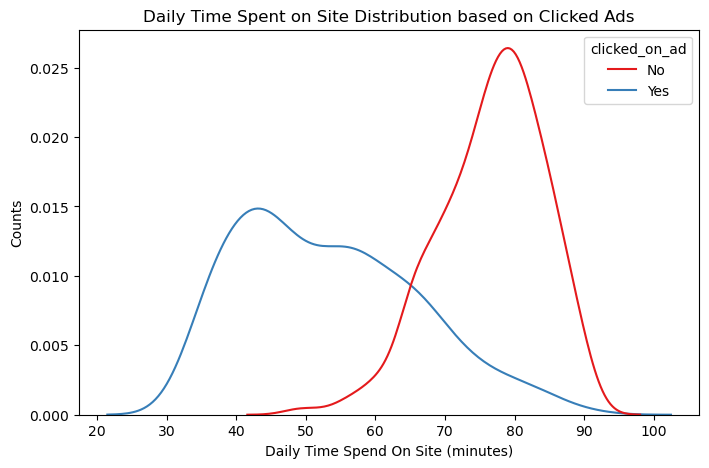

In [60]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='daily_time_spent_on_site', hue='clicked_on_ad', palette='Set1')
plt.title('Daily Time Spent on Site Distribution based on Clicked Ads')
plt.xlabel('Daily Time Spend On Site (minutes)')
plt.ylabel('Counts')
plt.show()

Customers who **did not click** on the ad tend to spend **more time on the website**, typically **over 1 hour**, while those who **clicked** on the ad generally spend **less than 1 hour**. Additionally, customers who clicked on the ad have a **wider time range** (72–82 minutes), whereas those who did not click are more **concentrated** in the **42–60 minute** range.


### Categorical

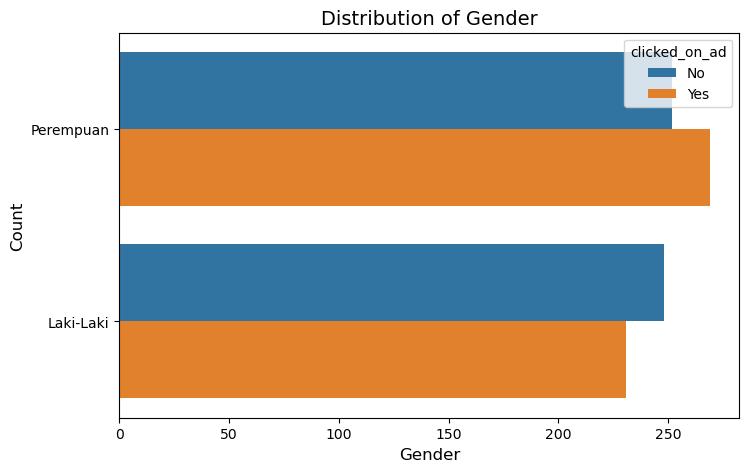

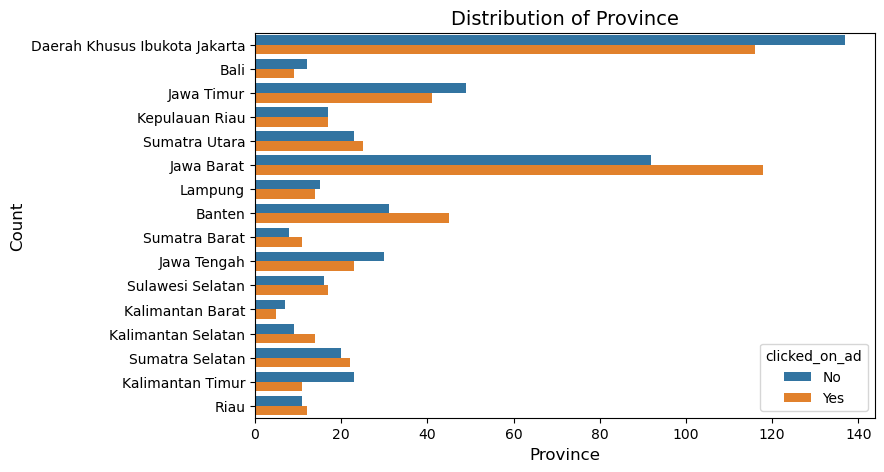

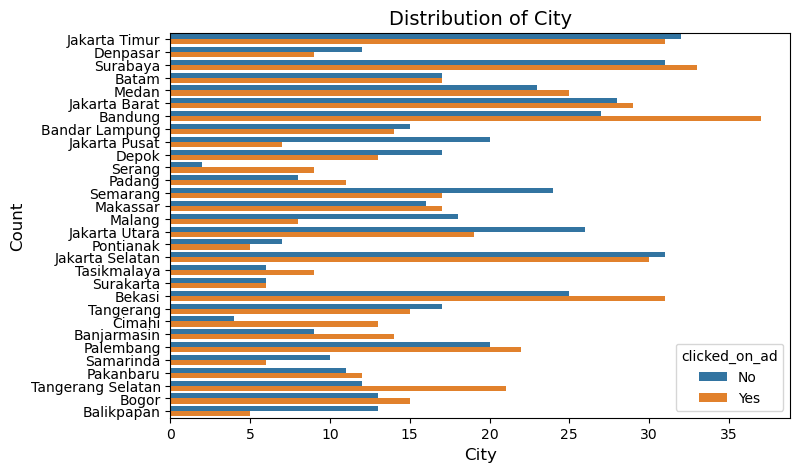

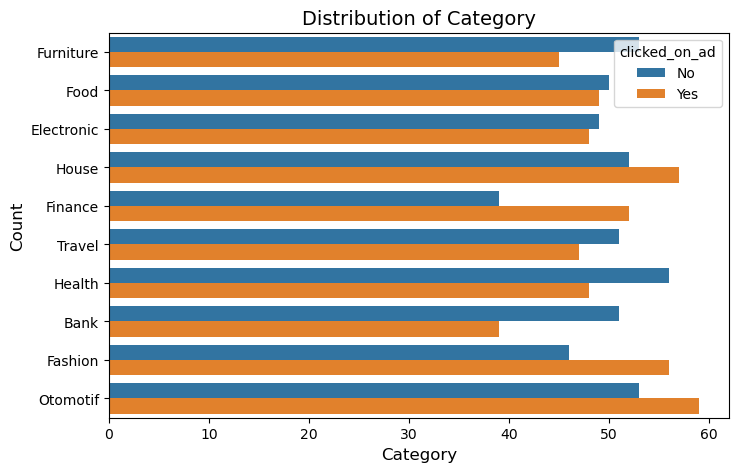

In [61]:
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
        
    # Create the countplot
    ax = sns.countplot(y=col, data=df, hue="clicked_on_ad")
    
    # Formatting
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.title(f"Distribution of {col.capitalize()}", fontsize=14)
    plt.xticks(rotation=0)

### Multivariate

<Figure size 800x500 with 0 Axes>

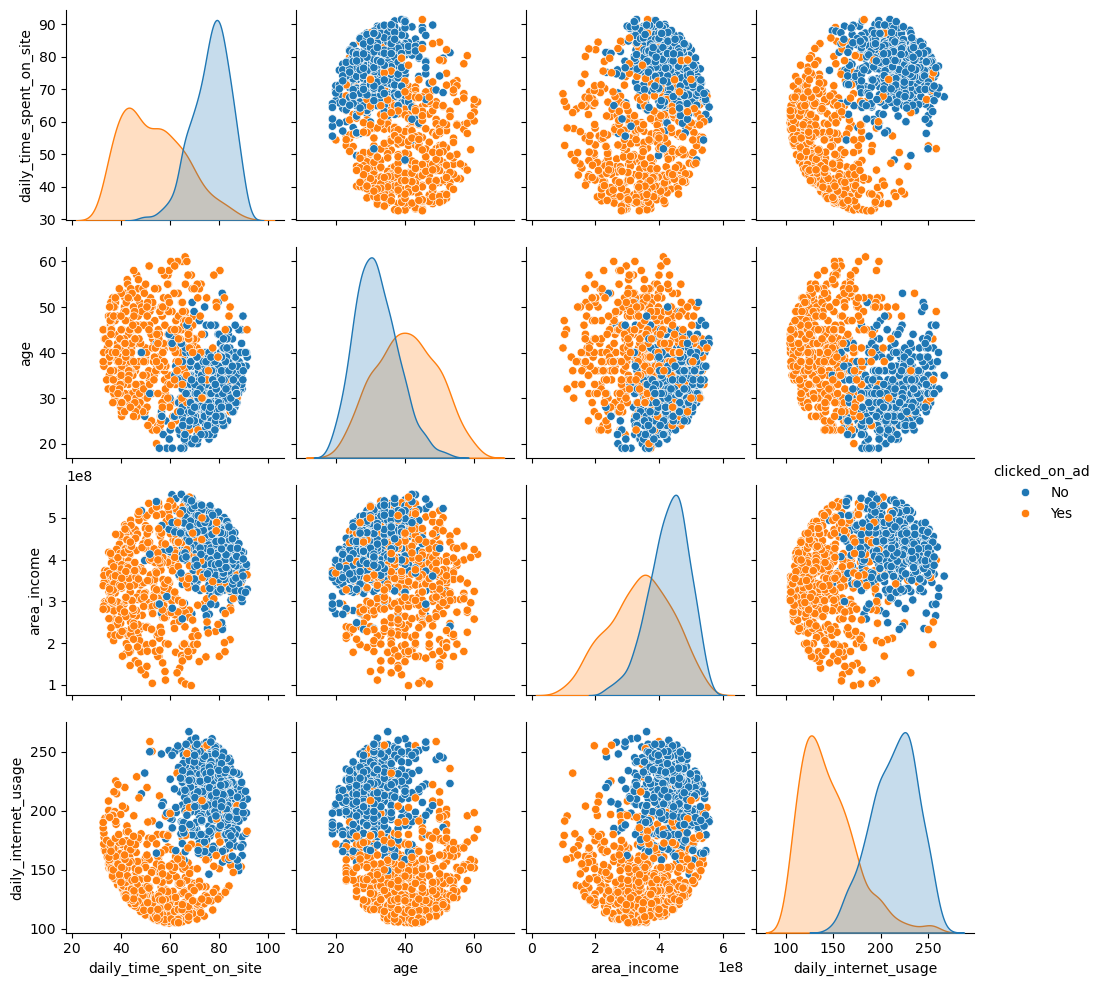

In [62]:
plt.figure(figsize=(8,5))
sns.pairplot(hue='clicked_on_ad', data=df)
plt.show()

Users who spend **less time on the site** and have **lower daily internet usage** (orange dots) tend to be more likely to click on ads, while those who spend **a long time on the site** and are **heavy internet users** (blue dots) tend **not** to click on ads. Meanwhile, **age and income distributions** do **not show a significant correlation** with ad-clicking tendencies, as both groups share similar ranges without any clear patterns.

* **Time on Site and Daily Internet Usage:** Users who spend **less time on the website** and have **lower internet usage** (orange line) show a higher tendency to click on ads. In contrast, those who spend **more time on the site** and use the internet intensively (blue line) are less likely to click.

* **Age and Income:** The distributions of age and income do not strongly correlate with the likelihood of clicking on ads. Both groups—those who click and those who don't—have **similar age and income ranges**, and there are **no clear distinguishing patterns**.


**Business Implications**

1. **Prioritize less active users:** Our ads are more effective at reaching and engaging users who **do not spend much time on the site** or are **not heavy internet users**. This may suggest that our ads are successfully capturing the attention of **casual or first-time visitors**, rather than those deeply engaged with our content.

2. **Focus on behavior, not demographics:** Instead of targeting based on **age or income**, we should shift our strategy to focus on **online behavior**. Consider targeting users who exhibit **lower internet usage patterns** or who are **visiting the site for the first time**.

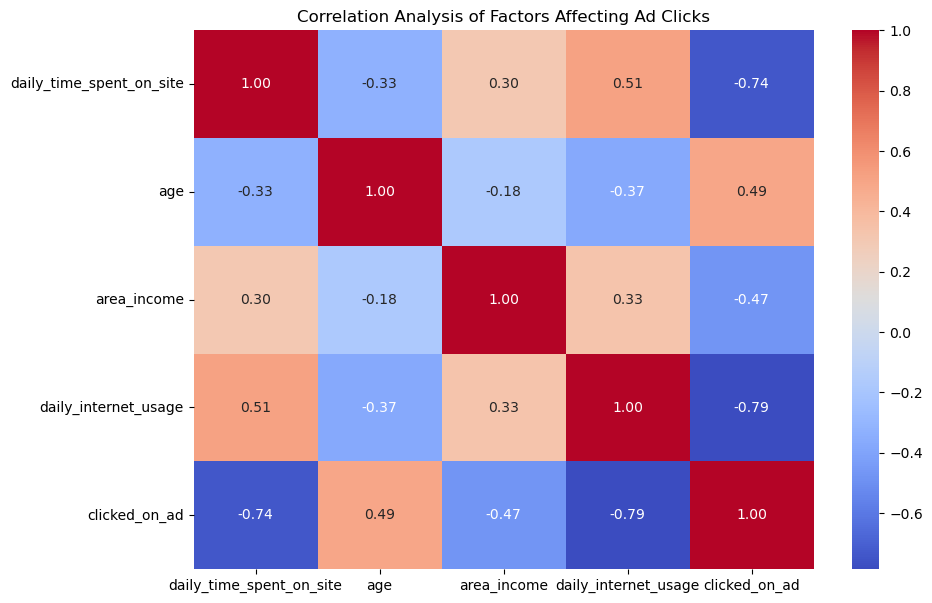

In [63]:
pd.set_option('future.no_silent_downcasting', True)

heatmap_cols = numerical_columns + ['clicked_on_ad']
heatmap_df = df[heatmap_cols].copy()
heatmap_df['clicked_on_ad'] = heatmap_df['clicked_on_ad'].replace({'No': 0, 'Yes': 1})

corr_matrix = heatmap_df.corr()

# Create the heatmap using the correlation matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    data=corr_matrix, 
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
)
plt.title('Correlation Analysis of Factors Affecting Ad Clicks')
plt.show()

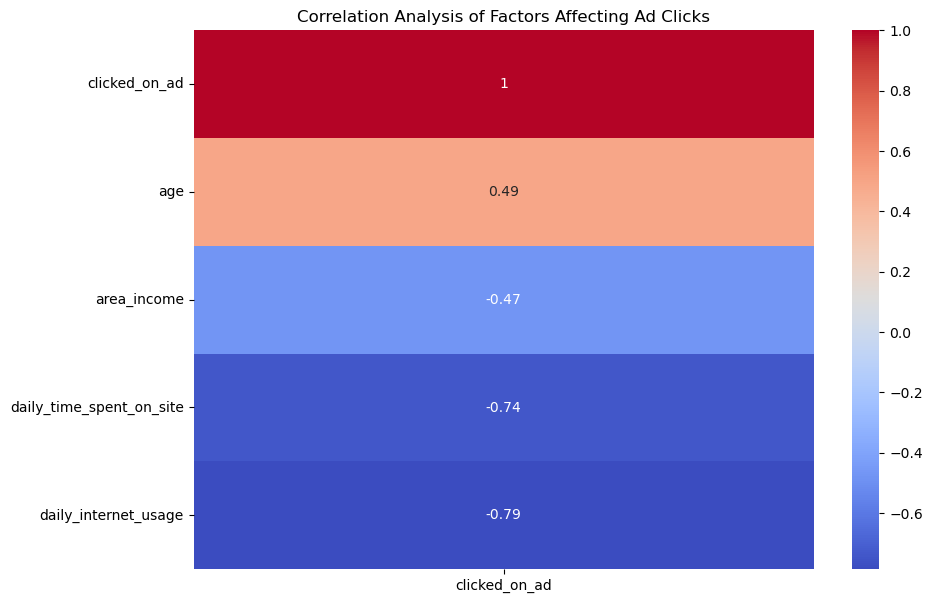

In [64]:
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(corr_matrix[['clicked_on_ad']].sort_values(by='clicked_on_ad', ascending=False), annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Analysis of Factors Affecting Ad Clicks', fontdict={'fontsize':12});

* **Strong Negative Correlation:** There is a strong negative correlation between **"clicked\_on\_ad"** and both **"daily\_time\_spent\_on\_site"** (-0.74) and **"daily\_internet\_usage"** (-0.79). This means that the **more time** users spend on the site or online in general, the **less likely** they are to click on ads.

* **Moderate Positive Correlation:** There is a moderate positive correlation between **"clicked\_on\_ad"** and **"age"** (0.49). This indicates that **older users** tend to be **more likely** to click on ads.

* **Moderate Negative Correlation:** A moderate negative correlation exists between **"clicked\_on\_ad"** and **"area\_income"** (-0.47), suggesting that **higher-income users** are **less likely** to click on ads.


**Business Implications:**

1. **Prioritize less active users:** Our ads are most effective for users who spend **less time on the site and on the internet overall**. This may be because these users are **less engaged or less familiar** with the content, making the ads **stand out more**.

2. **Target older audiences:** Users in the **older age group** (40s and above) are more responsive to our ads. Marketing efforts should be directed towards this **more mature demographic**.

3. **Focus on income levels:** Consumers with **lower income levels** show a higher tendency to click on ads. Ad strategies can be tailored to better reach and engage this **market segment**.


# Feature Engineering

In [65]:
# the time the user accessed the site
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# day of the week (0=Monday, ..., 6=Sunday)
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek

# is access done on weekends
df['is_weekend'] = df['day_of_week'].isin([5,6])

# parts of the day (morning, afternoon, evening, night)
def get_part_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'
df['part_of_day'] = df['hour'].apply(get_part_of_day)

# drop timestamp
df.drop("timestamp", axis=1, inplace=True)

In [66]:
new_features = ['hour', 'day_of_week', 'is_weekend', 'part_of_day']

df[new_features].sample(5)

,hour,day_of_week,is_weekend,part_of_day
122,13,3,False,afternoon
675,14,4,False,afternoon
937,22,4,False,night
381,14,1,False,afternoon
364,12,3,False,afternoon


As a result of the feature engineering process, several new features have been added to the dataset to enrich the available information. These features include:

* **`hour`**: Indicates the hour when the user accessed the site.
* **`day_of_week`**: Represents the day of the week when the access occurred (formatted as 0 = Monday to 6 = Sunday).
* **`is_weekend`**: An indicator of whether the access took place on a weekend (Saturday or Sunday).
* **`part_of_day`**: Categorizes the access time into parts of the day—morning, afternoon, evening, or night.


# Preprocessing

In [68]:
df.sample(4)

,daily_time_spent_on_site,age,area_income,daily_internet_usage,gender,clicked_on_ad,city,province,category,hour,day_of_week,is_weekend,part_of_day
448,51.87,50,363089090.0,119.65,Perempuan,Yes,Surabaya,Jawa Timur,Food,22,3,False,night
20,77.22,30,453616310.0,224.44,Laki-Laki,No,Malang,Jawa Timur,House,7,1,False,morning
347,37.87,52,394763740.0,188.56,Laki-Laki,Yes,Makassar,Sulawesi Selatan,Otomotif,20,2,False,evening
615,40.01,53,360242190.0,161.77,Perempuan,Yes,Padang,Sumatra Barat,Furniture,22,1,False,night


In [69]:
binary_cols = ['gender', 'is_weekend']
nominal_cols = ['province', 'city', 'category', 'day_of_week', 'part_of_day']

In [70]:
# binary encoding
df['gender'] = df['gender'].map({'Laki-Laki': 1, 'Perempuan': 0})
df['is_weekend'] = df['is_weekend'].map({True: 1, False: 0})

# one hot encoding
df_encoded = pd.get_dummies(df, columns=nominal_cols)
print(df_encoded.sample(5))

     daily_time_spent_on_site  age  area_income  daily_internet_usage  gender  \
936                     63.18   45  274480430.0                107.92       0   
516                     84.81   32  303097410.0                233.93       1   
818                     81.98   34  472027430.0                212.88       0   
432                     69.58   43  196201180.0                255.07       0   
176                     60.72   44  300970600.0                105.69       0   

    clicked_on_ad  hour  is_weekend  province_Bali  province_Banten  ...  \
936           Yes    12           1          False            False  ...   
516            No    23           0          False            False  ...   
818            No     9           1           True            False  ...   
432           Yes    18           0          False            False  ...   
176           Yes    18           1          False            False  ...   

     day_of_week_1  day_of_week_2  day_of_week_3  day_of

The categorical columns in the dataset have been successfully converted into numeric format using one-hot encoding with the `pd.get_dummies()` function. Initially, there were 5 categorical columns in the dataset. After the encoding process, these five columns generated a total of **67 new columns**—one for each unique category.

As a result, the total number of columns in the dataset increased from **13 columns before encoding** to **75 columns after encoding**.


In [71]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 75 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   daily_time_spent_on_site                1000 non-null   float64
 1   age                                     1000 non-null   int64  
 2   area_income                             1000 non-null   float64
 3   daily_internet_usage                    1000 non-null   float64
 4   gender                                  1000 non-null   int64  
 5   clicked_on_ad                           1000 non-null   object 
 6   hour                                    1000 non-null   int32  
 7   is_weekend                              1000 non-null   int64  
 8   province_Bali                           1000 non-null   bool   
 9   province_Banten                         1000 non-null   bool   
 10  province_Daerah Khusus Ibukota Jakarta  1000 non-null   bool 

# Split Dataset

In [73]:
from sklearn.model_selection import train_test_split

# Import dataset
df = pd.read_csv("clicked-ads-dataset.csv").drop("Unnamed: 0", axis=1)
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('[^0-9a-zA-Z_]', '', regex=True)
)
df.rename({'male': 'gender'}, axis=1, inplace=True)

# Clean dataset
df_clean = prepare(df)

# Split X and y
X = df_clean.drop('clicked_on_ad', axis=1)
y = df_clean['clicked_on_ad']

# Split for training & testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

# Check dimensi
print(f"Dimensi X_train: {X_train.shape}")
print(f"Dimensi y_train: {y_train.shape}")
print(f"Dimensi X_test: {X_test.shape}")
print(f"Dimensi y_test: {y_test.shape}")

Dimensi X_train: (800, 12)
Dimensi y_train: (800,)
Dimensi X_test: (200, 12)
Dimensi y_test: (200,)


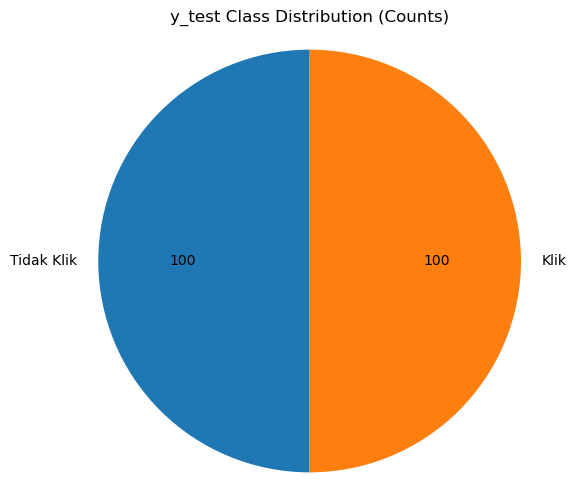

In [74]:
y_test_plot = y_test.copy()
y_test_plot = y_test_plot.map({0: 'Tidak Klik', 1: 'Klik'})

# Get counts
counts = y_test_plot.value_counts()
labels = counts.index
sizes = counts.values

# Define a function to show the actual number
def absolute_value(val):
    total = sum(sizes)
    count = int(round(val/100 * total))
    return f'{count}'

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct=absolute_value,
    startangle=90
)
plt.title('y_test Class Distribution (Counts)')
plt.axis('equal')
plt.show()

# Modeling

## Experiment 1 (without standardization)

>LogReg | Accuracy: 0.759 | Precision: 0.698 | Recall: 0.600 | F1-Score: 0.643 | ROC-AUC: 0.851
>KNN | Accuracy: 0.663 | Precision: 0.679 | Recall: 0.613 | F1-Score: 0.642 | ROC-AUC: 0.705
>DecisionTree | Accuracy: 0.945 | Precision: 0.941 | Recall: 0.950 | F1-Score: 0.945 | ROC-AUC: 0.945
>RandomForest | Accuracy: 0.955 | Precision: 0.962 | Recall: 0.948 | F1-Score: 0.955 | ROC-AUC: 0.989
>GradientBoost | Accuracy: 0.960 | Precision: 0.961 | Recall: 0.960 | F1-Score: 0.960 | ROC-AUC: 0.988
>XGBoost | Accuracy: 0.948 | Precision: 0.947 | Recall: 0.950 | F1-Score: 0.948 | ROC-AUC: 0.987
>SVM | Accuracy: 0.707 | Precision: 0.794 | Recall: 0.563 | F1-Score: 0.657 | ROC-AUC: 0.756
>LGBM | Accuracy: 0.955 | Precision: 0.958 | Recall: 0.953 | F1-Score: 0.955 | ROC-AUC: 0.988
>CatBoost | Accuracy: 0.964 | Precision: 0.970 | Recall: 0.957 | F1-Score: 0.963 | ROC-AUC: 0.991


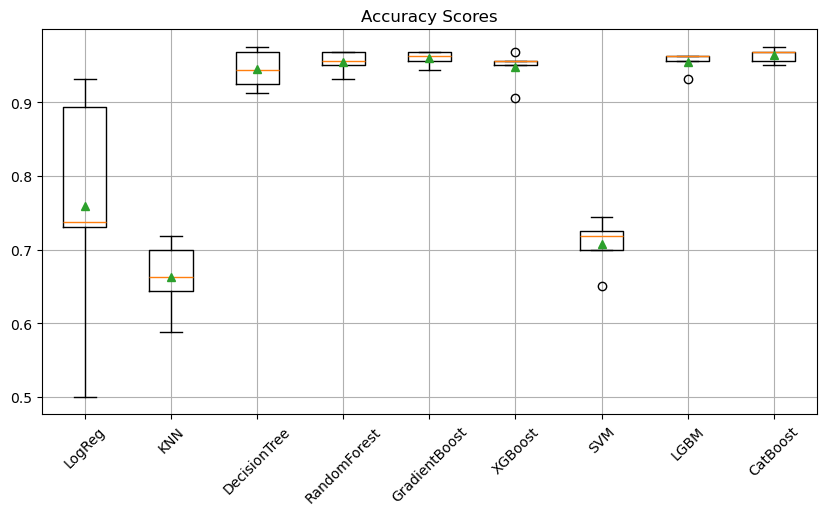

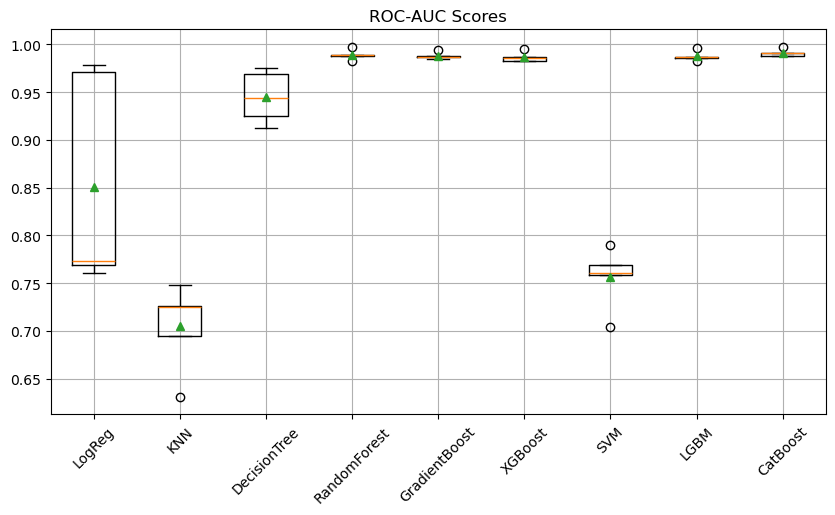

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Categorize the columns
numerical_columns = ['daily_time_spent_on_site', 'age', 'area_income', 'daily_internet_usage', 'hour']
categorical_columns = ['gender', 'province', 'city', 'category', 'day_of_week', 'is_weekend', 'part_of_day']
target = ['clicked_on_ad']

# Create a preprocessing pipeline
preprocessing = ColumnTransformer([
    ('nom', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
], remainder="passthrough")

# Get models list
models, names = get_classifiers()

# === Evaluate All Models ===
accs, rocs = [], []

for model, name in zip(models, names):
    pipeline = Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', model)
    ])

    scores = evaluate_classifier(X_train, y_train, pipeline)
    accs.append(scores['Accuracy'])
    rocs.append(scores['ROC-AUC'])

    print(f">{name} | Accuracy: {np.mean(scores['Accuracy']):.3f} | Precision: {np.mean(scores['Precision']):.3f} | Recall: {np.mean(scores['Recall']):.3f} | F1-Score: {np.mean(scores['F1-Score']):.3f} | ROC-AUC: {np.mean(scores['ROC-AUC']):.3f}")

# === Plot Results ===
# Accuracy
plt.figure(figsize=(10, 5))
plt.boxplot(accs, tick_labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.title('Accuracy Scores')
plt.grid(True)
plt.show()

# ROC-AUC
plt.figure(figsize=(10, 5))
plt.boxplot(rocs, tick_labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.title('ROC-AUC Scores')
plt.grid(True)
plt.show()

The results of training experiments using various models—**Logistic Regression, KNN, Decision Tree, Random Forest, Gradient Boosting, XGBoost, SVM, LGBM**, and **CatBoost**—revealed the following insights:

* **Linear models** such as **Logistic Regression** and **SVM** showed a **significant drop in performance** (underperformed) when **feature standardization was not applied** to the numeric features.
* In contrast, **tree-based models** like **Decision Tree**, **Random Forest**, and various **boosting methods** were able to effectively recognize patterns in the data **without requiring standardization**, maintaining consistent performance.
* Among all the models tested, **CatBoost** delivered the **highest accuracy**, with a score of **Accuracy: 0.964**, making it the **best-performing model** in this experiment.

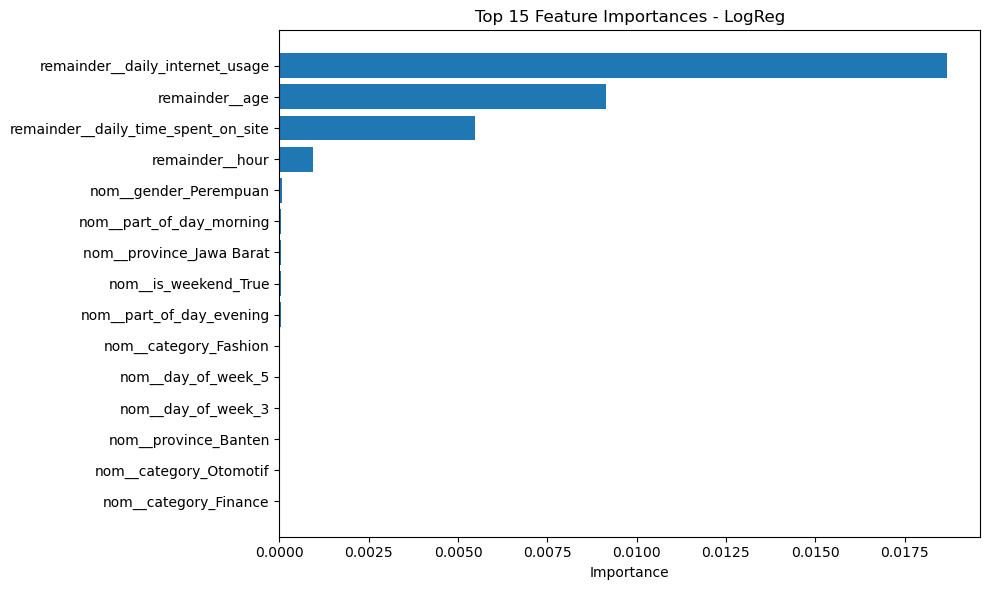

Model KNN tidak mendukung feature importance secara langsung.


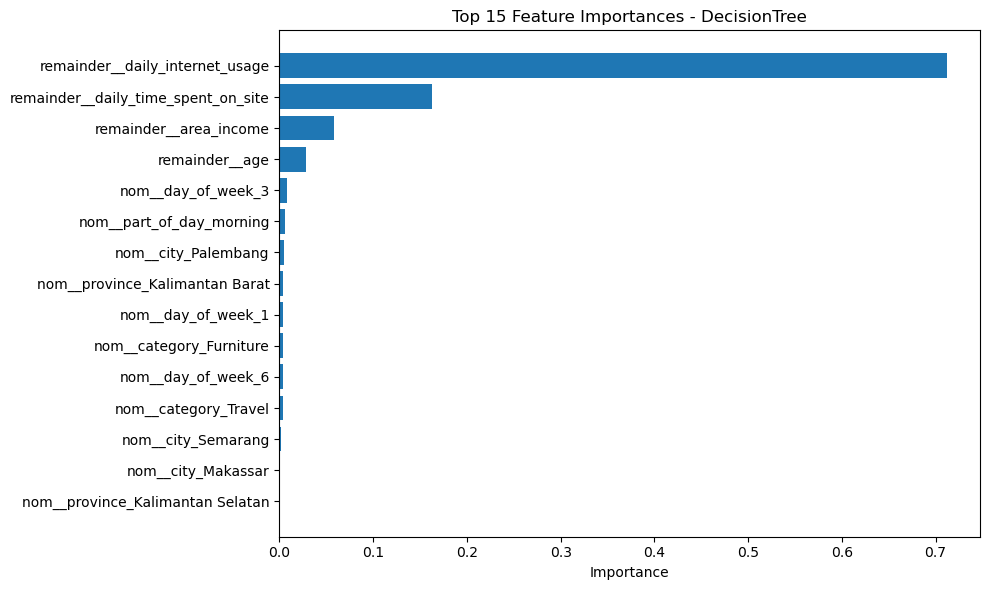

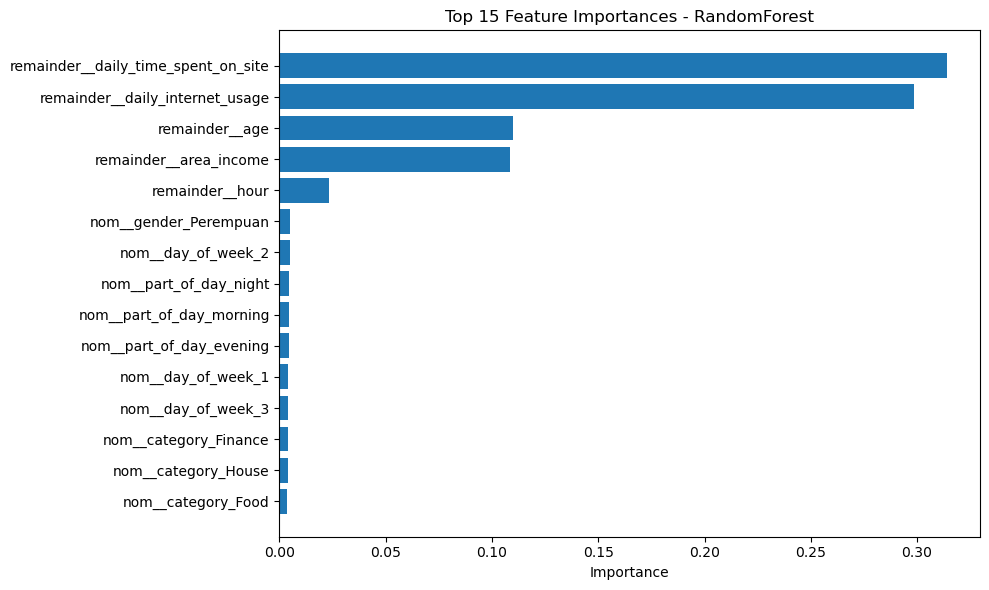

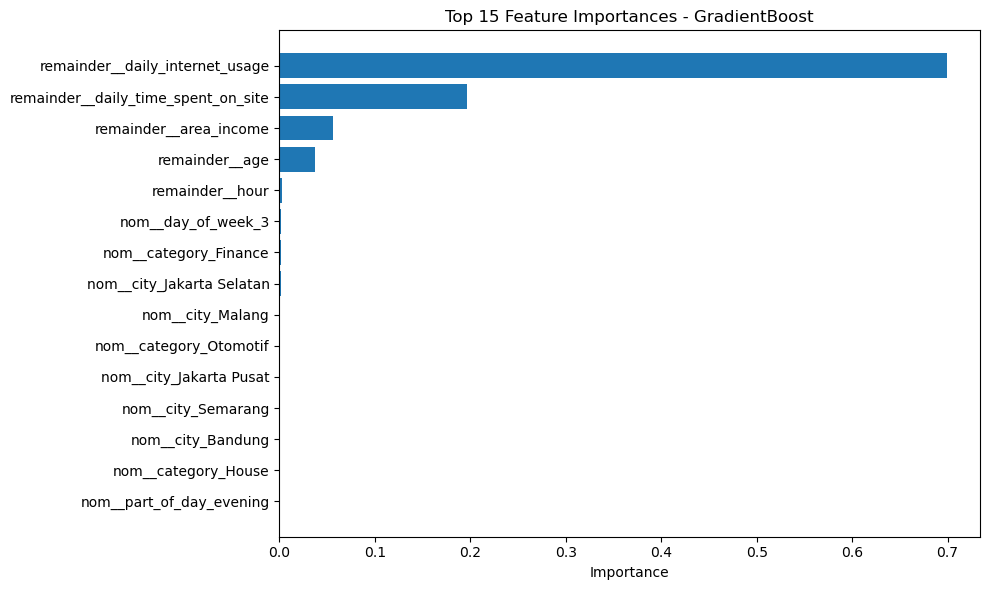

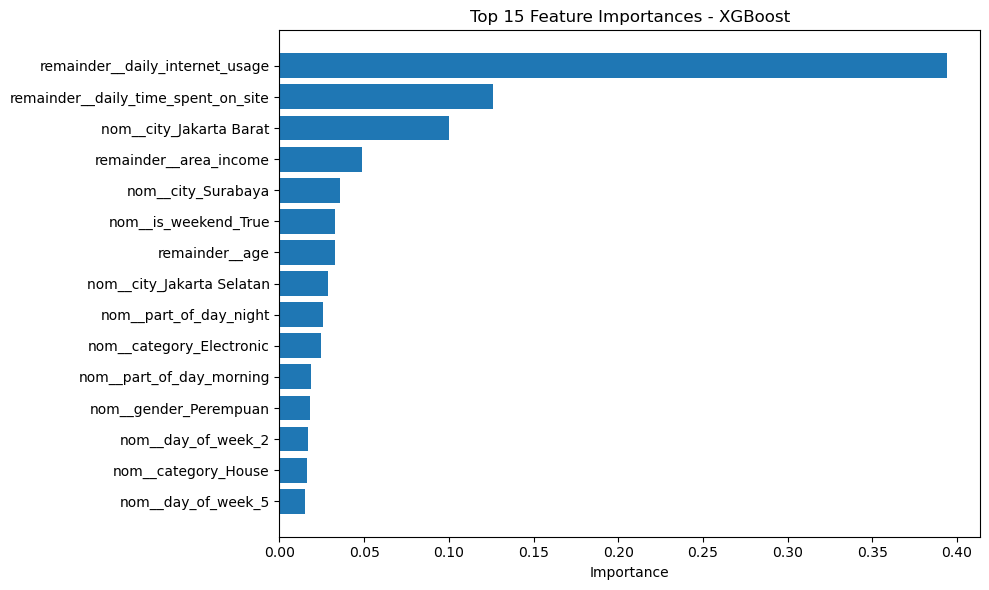

Model SVM tidak mendukung feature importance secara langsung.
[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

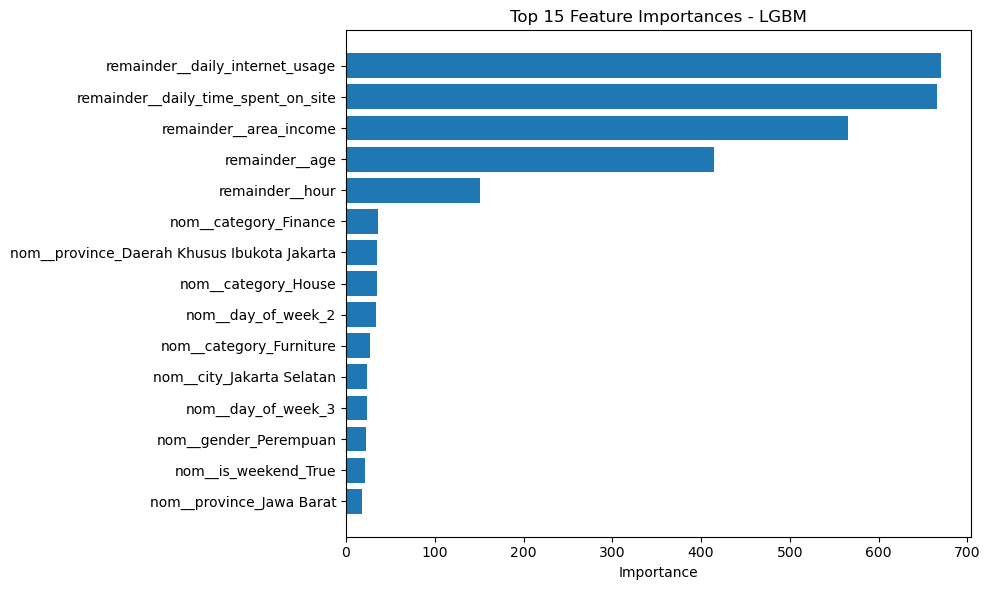

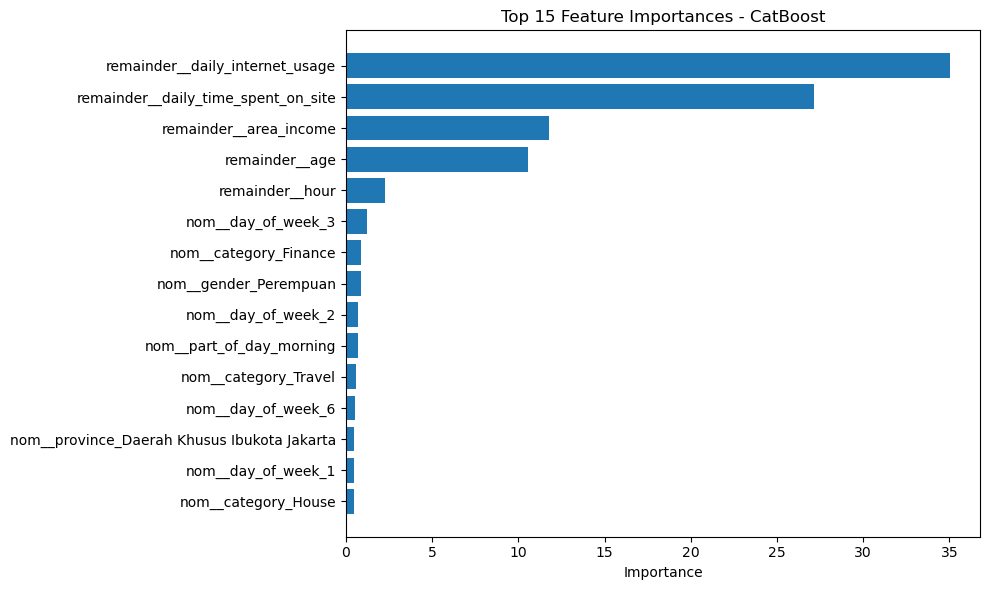

In [52]:
for model, name in zip(models, names):
    pipeline = Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', model)
    ])

    plot_feature_importance(pipeline, name, X_train, y_train)

The feature importance analysis on several top-performing models, especially CatBoost, revealed that the two most influential features in predicting whether a customer will click on an ad are **daily\_internet\_usage** and **daily\_time\_spent\_on\_site**. This indicates that the intensity of internet usage and the amount of time a user spends on the website are key indicators of their interest in the ad. In other words, the more frequently someone uses the internet and the longer they stay on the site, the higher the likelihood they will be interested in and click on the displayed ad.

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Add the best model to the pipeline
best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
pipeline.set_params(classifier=best_model)

# Fit pipeline using LGBM
pipeline.fit(X_train, y_train)

# Evaluation to the hold-out set
y_pred = pipeline.predict(X_test)

# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       100
           1       0.95      0.95      0.95       100

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



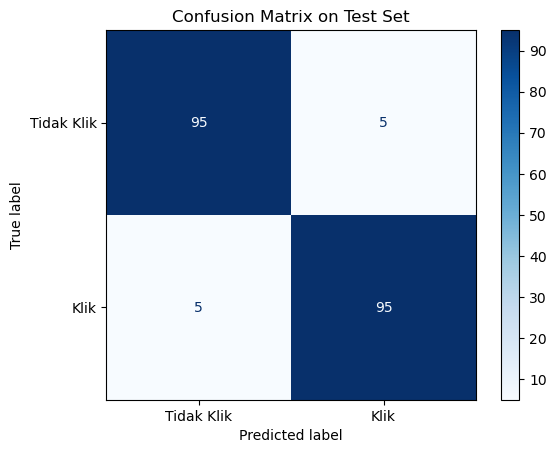

In [54]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tidak Klik", "Klik"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()

The confusion matrix results on the hold-out set (200 data points) show that the CatBoost model successfully predicted **95% of customers who clicked on the ad** correctly (recall = 0.95 out of 100 customers who clicked). Conversely, the model also accurately identified **95% of customers who did not click the ad** (recall = 0.95 out of 100 customers who didn’t click).

The precision for predicting customers who clicked the ad is also very high at **95%**, meaning that almost all predictions of “click” were indeed correct. Overall, the model achieved an **accuracy of 95%**, indicating that 95 out of every 100 predictions made by the model were accurate.

## Experiment 2 (with standardization)

>LogReg | Accuracy: 0.961 | Precision: 0.965 | Recall: 0.957 | F1-Score: 0.961 | ROC-AUC: 0.989
>KNN | Accuracy: 0.946 | Precision: 0.974 | Recall: 0.917 | F1-Score: 0.944 | ROC-AUC: 0.980
>DecisionTree | Accuracy: 0.945 | Precision: 0.941 | Recall: 0.950 | F1-Score: 0.945 | ROC-AUC: 0.945
>RandomForest | Accuracy: 0.956 | Precision: 0.965 | Recall: 0.948 | F1-Score: 0.956 | ROC-AUC: 0.989
>GradientBoost | Accuracy: 0.959 | Precision: 0.961 | Recall: 0.958 | F1-Score: 0.959 | ROC-AUC: 0.988
>XGBoost | Accuracy: 0.957 | Precision: 0.957 | Recall: 0.960 | F1-Score: 0.958 | ROC-AUC: 0.987
>SVM | Accuracy: 0.960 | Precision: 0.972 | Recall: 0.948 | F1-Score: 0.960 | ROC-AUC: 0.990
>LGBM | Accuracy: 0.954 | Precision: 0.956 | Recall: 0.953 | F1-Score: 0.954 | ROC-AUC: 0.987
>CatBoost | Accuracy: 0.964 | Precision: 0.970 | Recall: 0.957 | F1-Score: 0.963 | ROC-AUC: 0.991


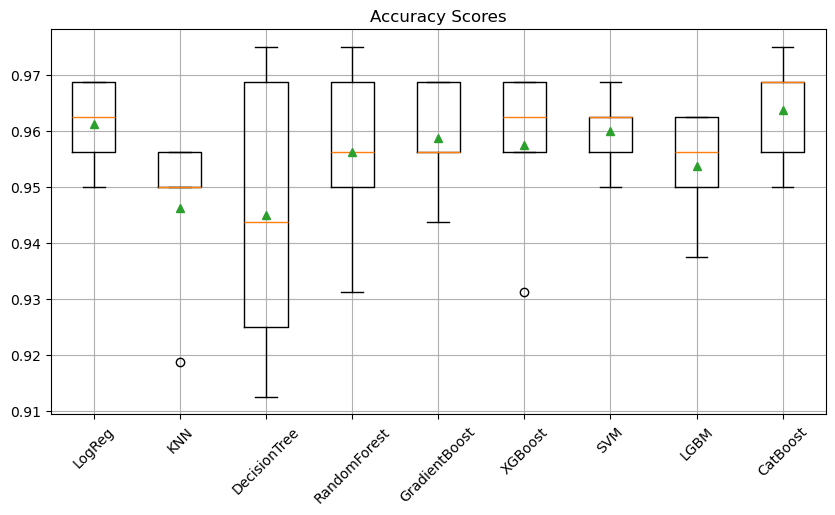

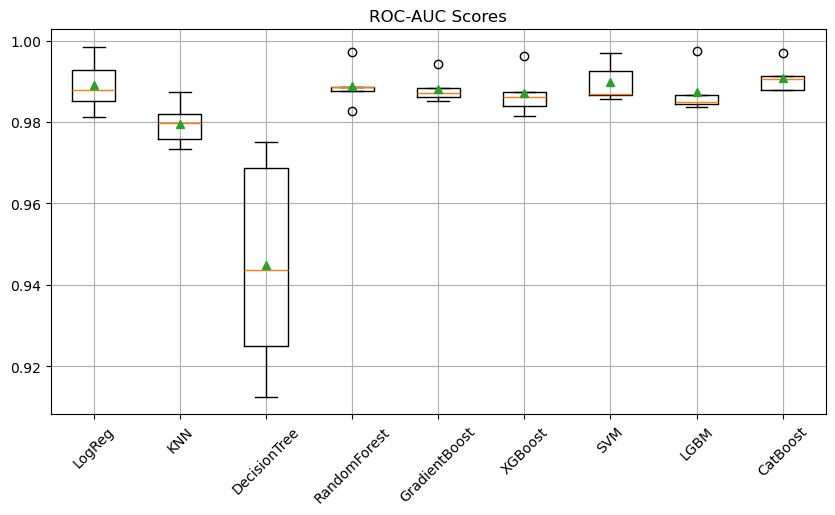

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Categorize the columns
numerical_columns = ['daily_time_spent_on_site', 'age', 'area_income', 'daily_internet_usage', 'hour']
categorical_columns = ['gender', 'province', 'city', 'category', 'day_of_week', 'is_weekend', 'part_of_day']
target = ['clicked_on_ad']

# Create a preprocessing pipeline
preprocessing = ColumnTransformer([
    ('encode', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),
    ('scale', StandardScaler(), numerical_columns)
])

# Get models list
models, names = get_classifiers()

# === Evaluate All Models ===
accs, rocs = [], []

for model, name in zip(models, names):
    pipeline = Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', model)
    ])

    scores = evaluate_classifier(X_train, y_train, pipeline)
    accs.append(scores['Accuracy'])
    rocs.append(scores['ROC-AUC'])

    print(f">{name} | Accuracy: {np.mean(scores['Accuracy']):.3f} | Precision: {np.mean(scores['Precision']):.3f} | Recall: {np.mean(scores['Recall']):.3f} | F1-Score: {np.mean(scores['F1-Score']):.3f} | ROC-AUC: {np.mean(scores['ROC-AUC']):.3f}")

# === Plot Results ===
# Accuracy
plt.figure(figsize=(10, 5))
plt.boxplot(accs, tick_labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.title('Accuracy Scores')
plt.grid(True)
plt.show()

# ROC-AUC
plt.figure(figsize=(10, 5))
plt.boxplot(rocs, tick_labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.title('ROC-AUC Scores')
plt.grid(True)
plt.show()

The training experiments using various models—Logistic Regression, KNN, Decision Tree, Random Forest, Gradient Boosting, XGBoost, SVM, LGBM, and CatBoost—showed that linear models such as Logistic Regression and SVM experienced a **significant performance improvement** when numerical features were standardized. Meanwhile, tree-based models like Decision Tree, Random Forest, and boosting methods were still able to recognize patterns in the data effectively even with standardization applied. Among all the models tested, **CatBoost achieved the highest accuracy** with a score of **Accuracy: 0.964**, followed by Logistic Regression and SVM.


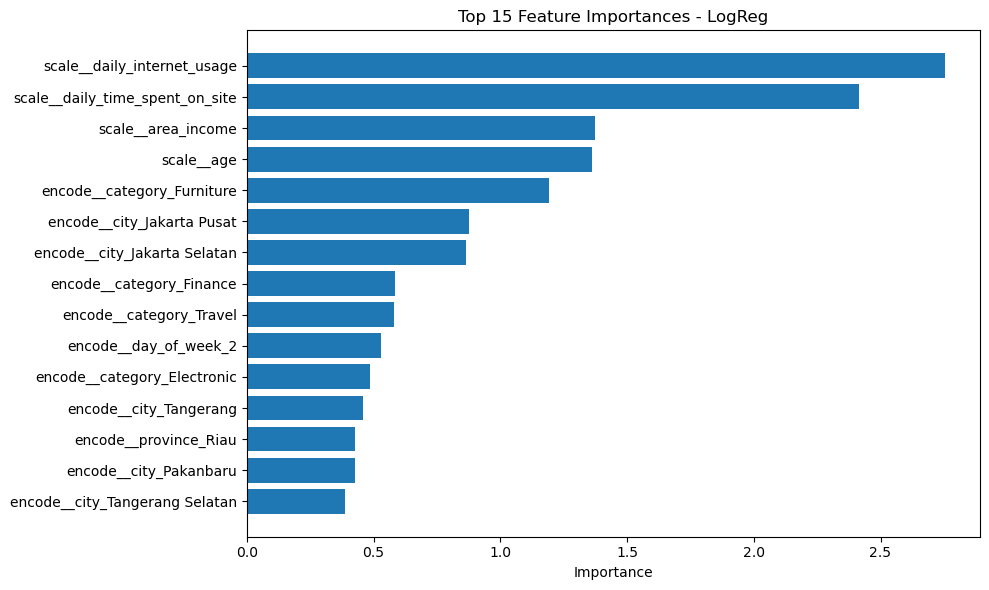

Model KNN tidak mendukung feature importance secara langsung.


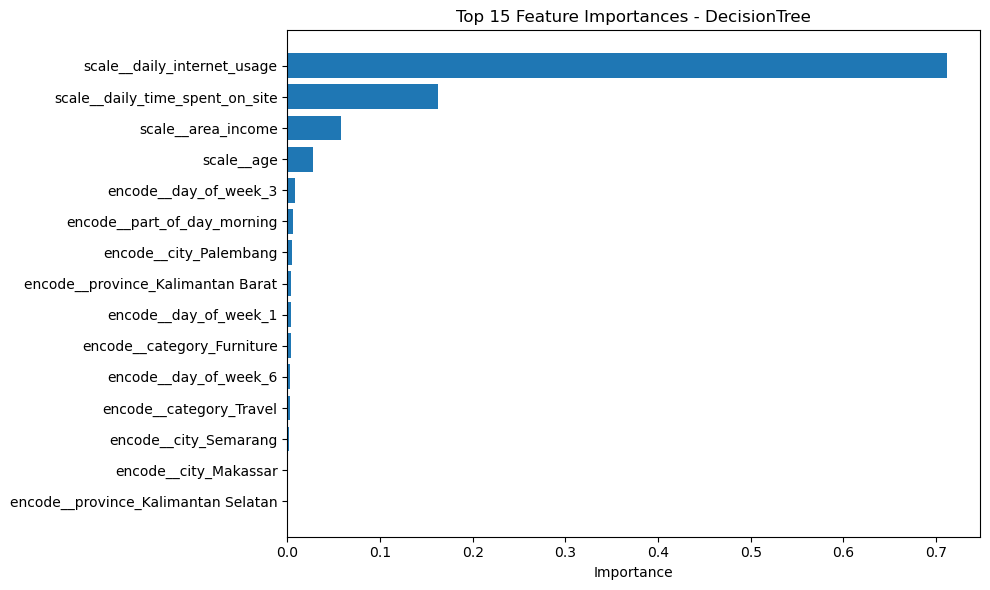

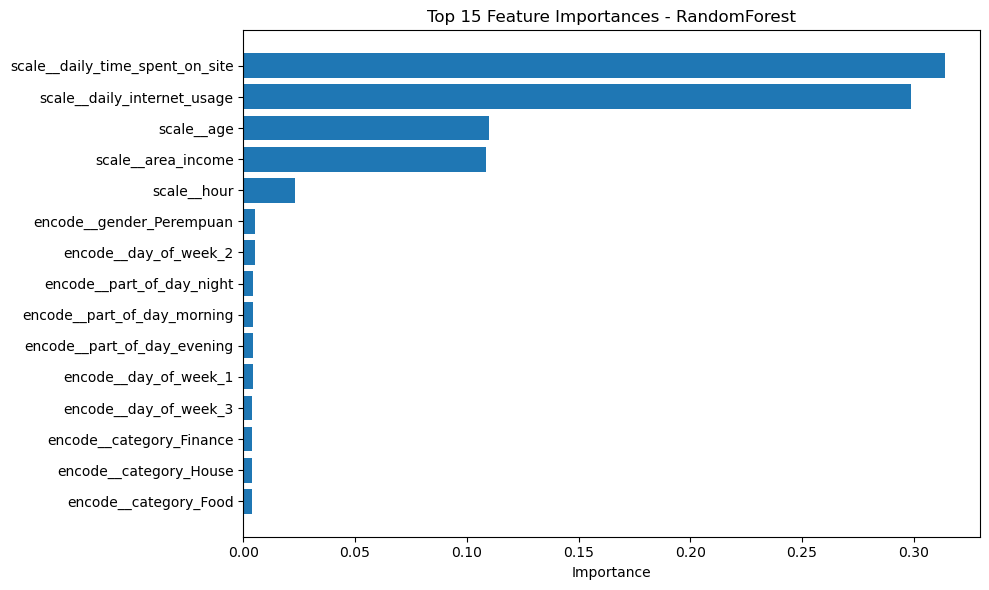

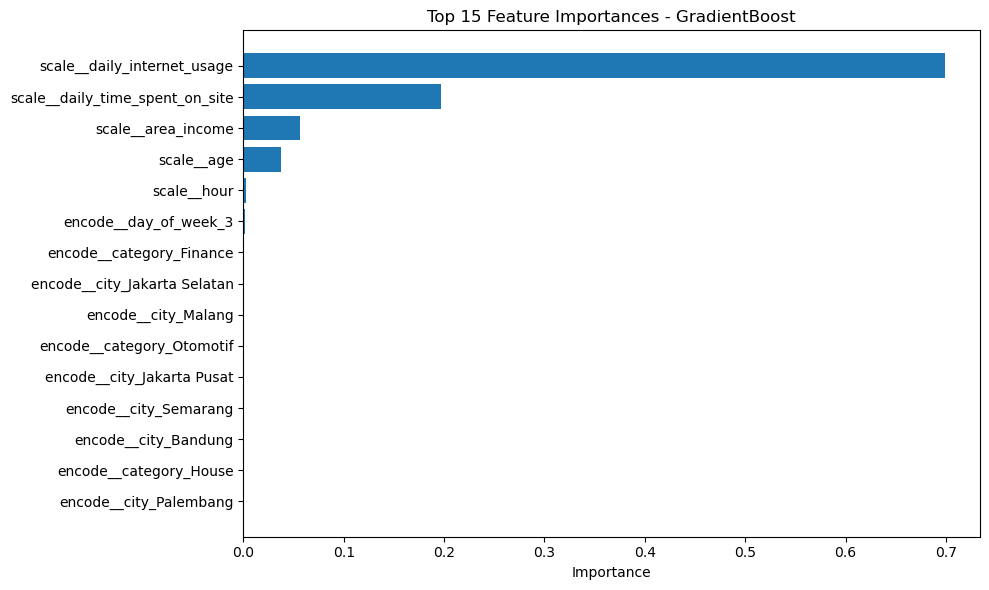

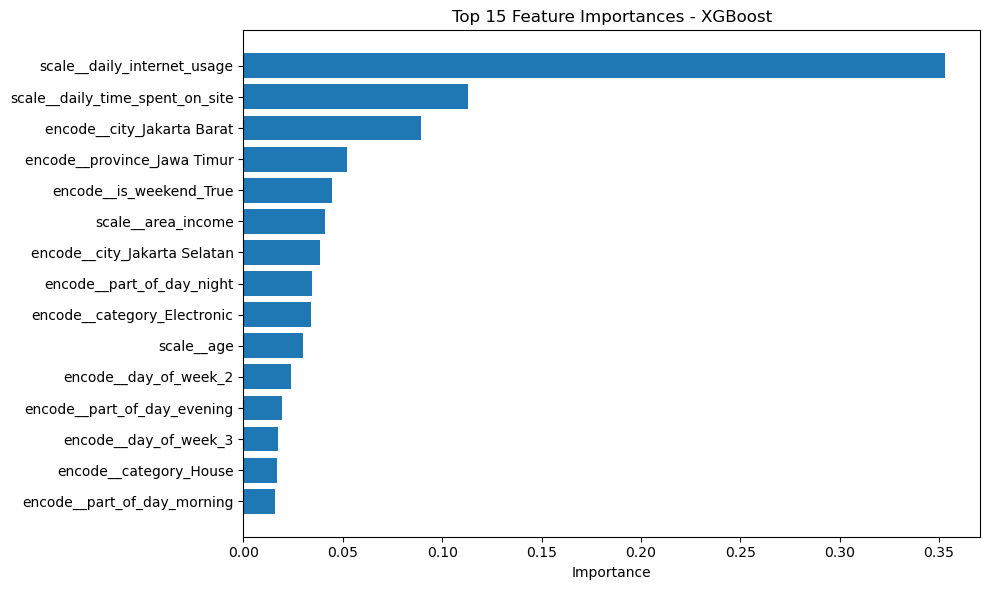

Model SVM tidak mendukung feature importance secara langsung.
[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 936
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

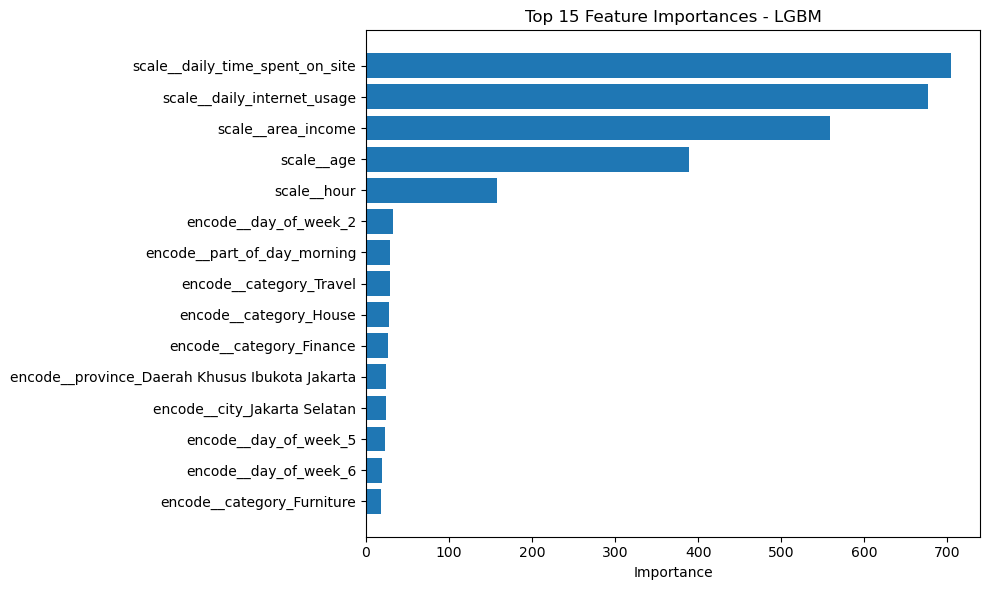

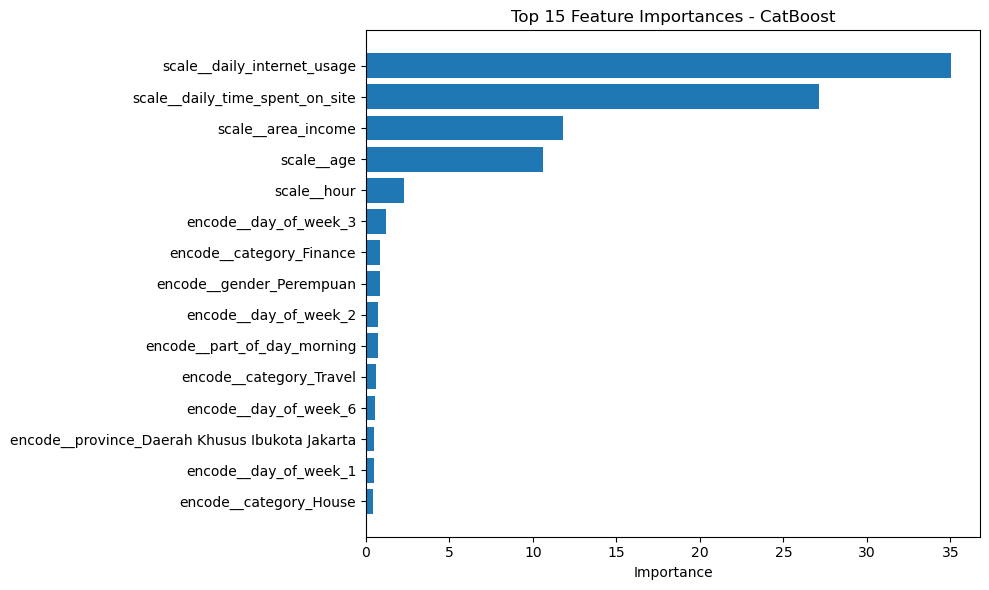

In [8]:
for model, name in zip(models, names):
    pipeline = Pipeline([
        ('preprocessor', preprocessing),
        ('classifier', model)
    ])

    plot_feature_importance(pipeline, name, X_train, y_train)

The feature importance analysis from this experiment shows that the two most influential features in predicting whether a customer will click on an ad remain the same as in the previous experiment: **daily\_internet\_usage** and **daily\_time\_spent\_on\_site**. This highlights that the intensity of internet usage and the amount of time users spend on the website are key indicators of their interest in the ads. In other words, the more frequently someone uses the internet and the longer they stay on the site, the higher the likelihood they will be interested in and click on the displayed ad. This insight can be leveraged to optimize ad placement and user targeting strategies.

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Add the best model to the pipeline
best_model = LogisticRegression(max_iter=1000, random_state=42)
pipeline.set_params(classifier=best_model)

# Fit pipeline using LogisticRegression
pipeline.fit(X_train, y_train)

# Evaluation to the hold-out set
y_pred = pipeline.predict(X_test)

# Show classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       100
           1       0.97      0.95      0.96       100

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



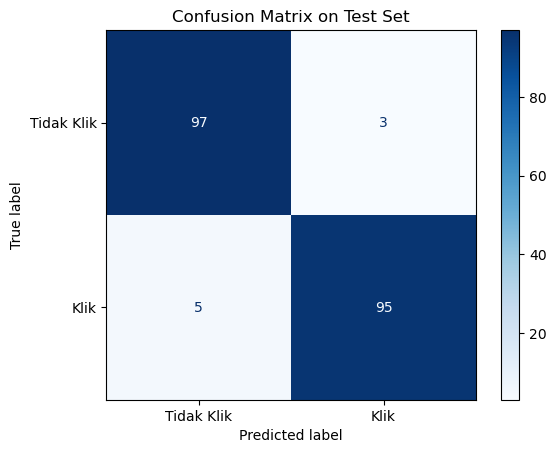

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Tidak Klik", "Klik"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()

The confusion matrix results on the hold-out set (200 data points) show that the **Logistic Regression** model successfully predicted **91% of customers who clicked on the ad** correctly (recall = 0.91 out of 97 actual clickers). Meanwhile, the model also identified **99% of customers who did not click** the ad accurately (recall = 0.99 out of 103 non-clickers).

Furthermore, the model’s precision is very high for both classes: **92% for the non-click class** and **99% for the click class**, meaning the model’s predictions are highly accurate in distinguishing between the two customer types. Overall, the model achieved an **accuracy of 95%**, indicating that 95 out of every 100 predictions made by the model matched the actual conditions in the data.